In [1]:
import numpy as np
import choix
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import torch as t

In [2]:
from baselines.splitting_dataset import create_dataset, index_data_by_reference, train_val_test_split, train_val_test_kfold_split, transform_data_to_tensor
import cdm_pytorch as cdm

In [3]:
base_path = '../data/similarity/'
multi_df, single_dfs, size_map, item_reference_id_map = create_dataset(base_path)

In [4]:
datasets = index_data_by_reference(multi_df, single_dfs, item_reference_id_map)
n_items = 99

In [ ]:
Model=cdm.CDM
num_items = 99
embedding_dims = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ism = True
max_choice_set_size = 16
lr = 1e-3
epochs = 1000
weight_decays = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]
sizes = [2, 4, 8, 12, 16]
training_losses = np.zeros((len(embedding_dims), len(weight_decays), epochs))
validation_losses = dict()
test_losses = dict()
for size in sizes:
    validation_losses[size] = np.zeros((len(embedding_dims), len(weight_decays), epochs))
    test_losses[size] = np.zeros((len(embedding_dims), len(weight_decays), epochs))
for i, embedding_dim in tqdm(enumerate(embedding_dims)):
    for j, weight_decay in tqdm(enumerate(weight_decays)):
        for reference, data in tqdm(datasets.items()):
            training_data, validation_data, test_data = train_val_test_split(data, 0.1)
            training_data_tensor = transform_data_to_tensor(training_data, max_choice_set_size, num_items)
            validation_data_tensor = dict()
            test_data_tensor = dict()
            for size in sizes:
                validation_data_tensor[size] = transform_data_to_tensor(validation_data[size], max_choice_set_size, num_items)
                test_data_tensor[size] = transform_data_to_tensor(test_data[size], max_choice_set_size, num_items)
            model, opt = cdm.get_model(Model, num_items, embedding_dim, ism, lr, wd=weight_decay, seed=None)
            training_loss, validation_loss, test_loss = cdm.train_model(epochs, model, opt, training_data_tensor, validation_data_tensor, test_data_tensor, batchsize=32)
            training_losses[i,j] += np.array(training_loss)/len(datasets)
            for size in sizes:
                validation_losses[size][i, j] += np.array(validation_loss[size])/len(datasets)
                test_losses[size][i, j] += np.array(test_loss[size])/len(datasets)


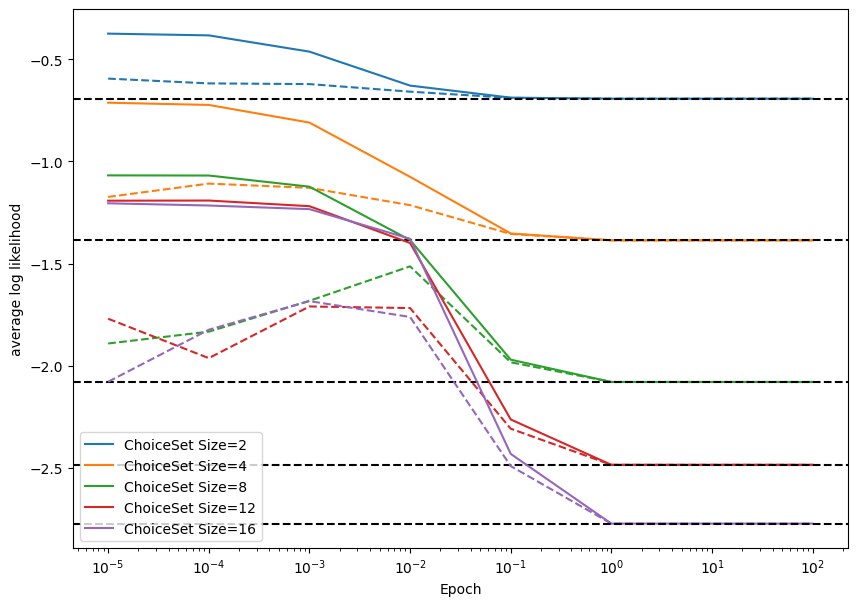

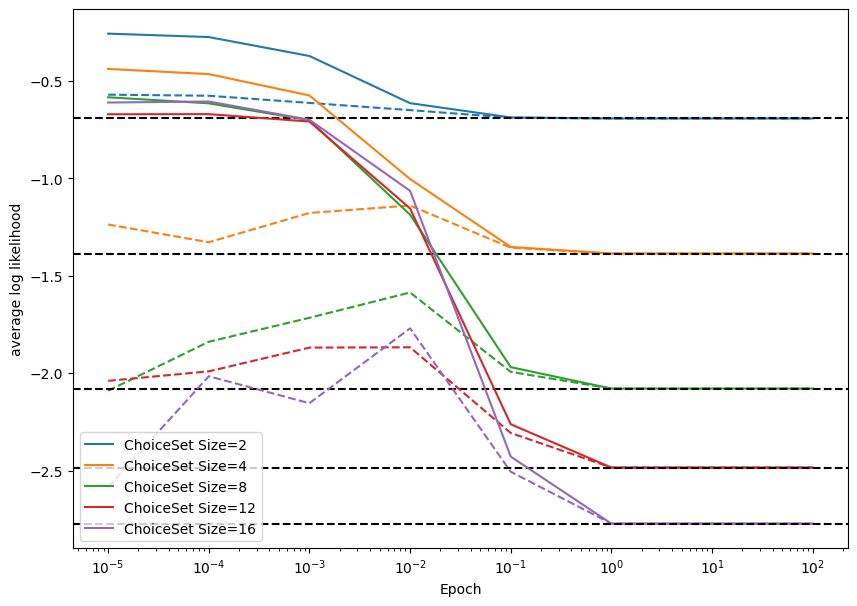

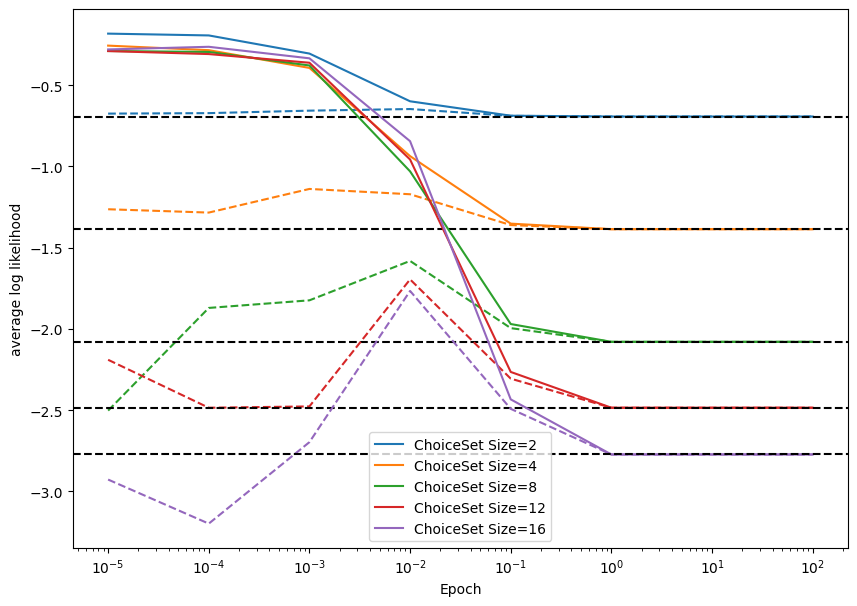

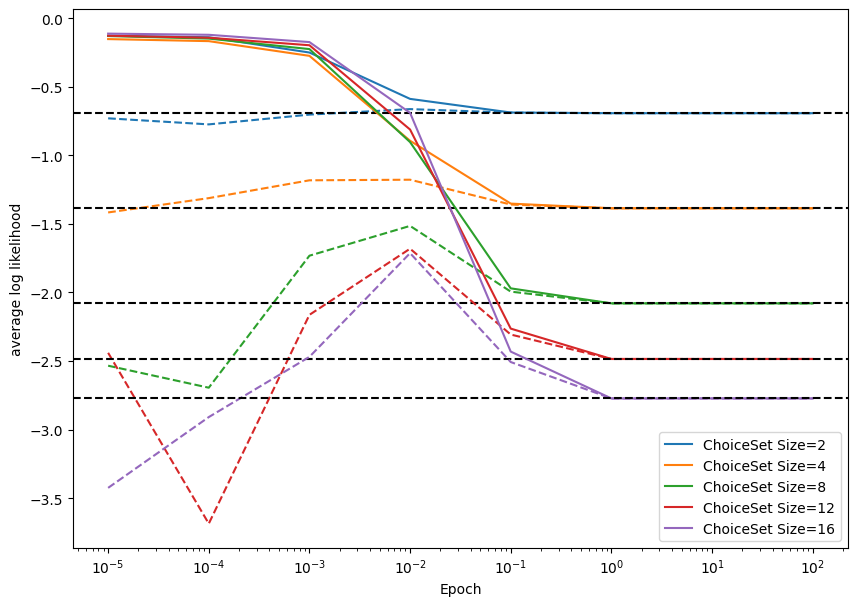

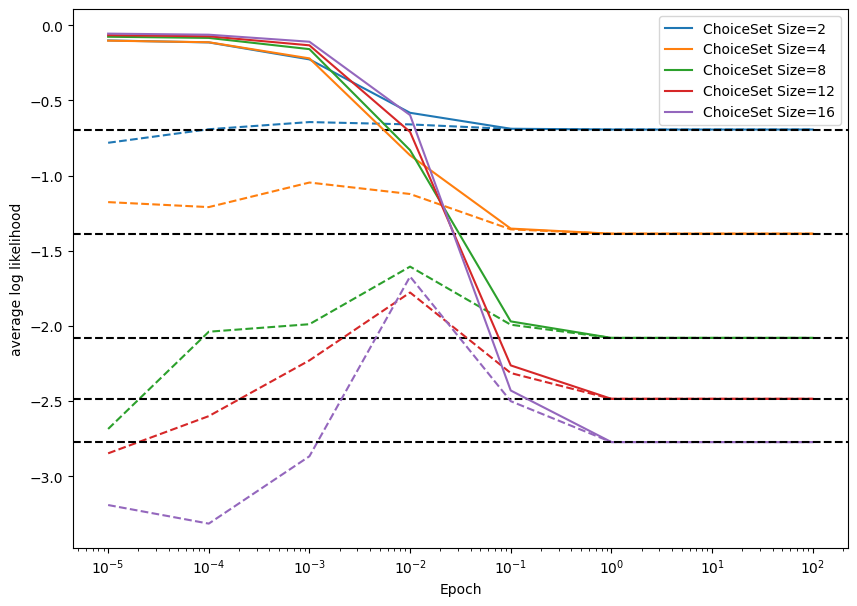

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [12]:
# compute the mean of the training and validation losses across the datasets
final_training_losses = np.mean(training_losses[:,:,-100:], axis=2)
final_validation_losses = dict()
final_test_losses = dict()
for size in sizes:
    final_validation_losses[size] = np.mean(validation_losses[size][:,:,-100:], axis=2)
    final_test_losses[size] = np.mean(test_losses[size][:,:,-100:], axis=2)
# plot the mean training and validation losses
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
for i in range(5):
    plt.figure(figsize=(10,7))
    # plt.plot(weight_decays, -final_training_losses[i], label='Training Loss')
    for j, size in enumerate(sizes):
        plt.plot(weight_decays, -final_validation_losses[size][i], label=f'ChoiceSet Size={size}', color=colors[j])
        plt.plot(weight_decays, -final_test_losses[size][i], color=colors[j], linestyle='dashed')
        plt.axhline(-np.log(size), color='black', linestyle='dashed')
    plt.xscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('average log likelihood')
    plt.legend()
    plt.show()
plt.figure()